In [157]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import os
import glob
import copy
import pickle

from BSA3_pack import *

from struct import unpack
from scipy import signal
from tqdm import tqdm_notebook
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import Angle
from itertools import permutations


import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Функция для создания последовательности временных значений для оси OX
def get_time(time_start, resolution, point):
    time = time_start + point*float(resolution)*u.millisecond
    return time

In [12]:
pulsar = '1133+16'

In [13]:
%%time
big_filename = './data_pntht/1133+16/010618_21_N2_00.pnthr'
filename = './data_pnt/' + pulsar + '/300618_19_N2_00.pnt'
# filename = './data_pnt/1237+25/040518_00_N1_00.pnt'
header, data = read_pnt(filename)

Wall time: 44 ms


In [14]:
print('npoints = ', len(data), '\n',
      'modules = ', len(data[0]), '\n',
      'rays = ', len(data[0][0]), '\n',
      'bands = ', len(data[0][0][0]))

npoints =  36017 
 modules =  6 
 rays =  8 
 bands =  7


In [15]:
obs_points = 4*u.min/(float(header['tresolution'][0])*u.millisecond).to(u.min)
obs_points = int(round(obs_points.value, 0))
# Определяем добавку для достижения размера массива 2**n
x = bin(obs_points)
x_high = '0b1' + '0'*(len(x[2:]))
add_points = int(x_high, 2) - obs_points
print(add_points, obs_points + add_points)
obs_points += add_points

1695 4096


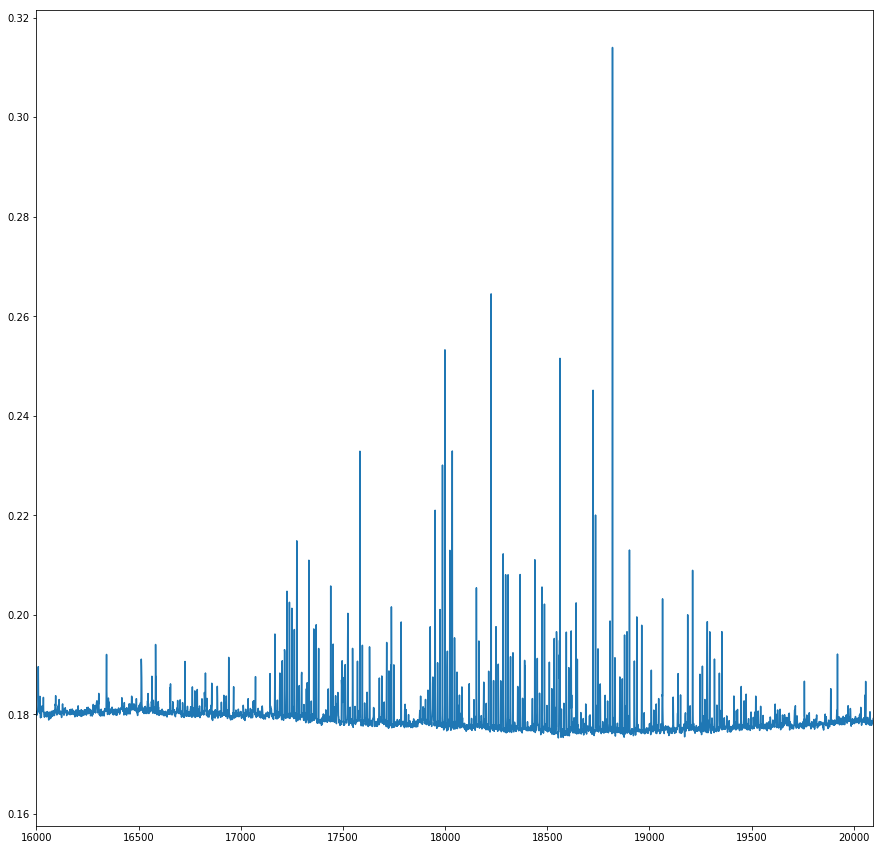

Wall time: 340 ms


In [16]:
%%time
module_1 = 2
module_2 = 5
ray_1 = 3
ray_2 = 8
chanel = 7
start_p = 16000
stop_p = start_p + obs_points

fig, ax = plt.subplots(figsize=(15, 15))

ax.plot([j[module_1-1][ray_1-1][chanel-1] for j in data])
#ax.plot([j[module_2-1][ray_2-1][chanel-1] for j in data])
plt.xlim(start_p, stop_p)
plt.show()

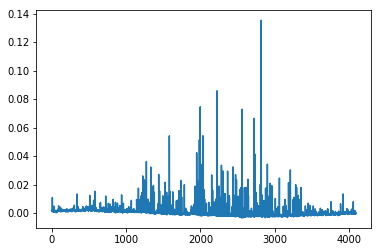

In [17]:
puls_data = [j[module_1-1][ray_1-1][chanel-1] for j in data[start_p:stop_p]]
sig = puls_data - np.median(puls_data)
plt.plot(sig)
plt.show()

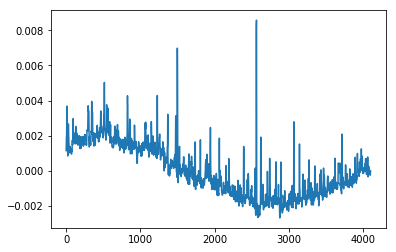

In [18]:
res_filter = signal.medfilt(sig, kernel_size=7)
plt.plot(res_filter)
plt.show()

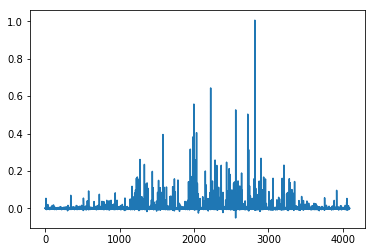

In [19]:
filtred_sig = (sig - res_filter)/max(sig)
plt.plot(filtred_sig)
plt.show()

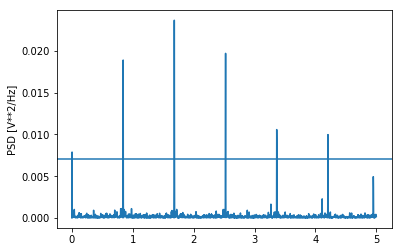

In [20]:
fs = 10 # понять физический смысл этого числа
f, Pxx_den = signal.periodogram(filtred_sig, fs)
plt.plot(f, Pxx_den)
plt.ylabel('PSD [V**2/Hz]')
plt.axhline(0.3*max(Pxx_den))
#plt.ylim(0, 0.00003)
#plt.xlim(1.4, 1.6)
plt.show()

In [23]:
points = np.argwhere(np.diff(np.sign(Pxx_den - 0.3*np.max(Pxx_den)))).flatten()
periods_harms = []
for i in points:
    periods_harms.append(f[i])
    print(f[i])

0.0
0.00244140625
0.83740234375
0.84228515625
1.6796875
1.6845703125
2.51953125
2.5244140625
3.36181640625
3.36669921875
4.2041015625
4.20654296875


In [930]:
time_start, time_end = get_time_begin_and_end(header)
start_point = get_time(time_start, header['tresolution'][0], start_p)
end_point = get_time(time_start, header['tresolution'][0], stop_p)
to_log = (start_point, end_point, periods_harms, filtred_sig,)
with open(os.path.basename(filename)[:-4] + '_part_' + pulsar + '.log', 'wb') as file:
    pickle.dump(to_log, file)